# Mushroom Classifer Project

In [2]:
import os

In [6]:
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
#from tqdm import tqdm
import pandas as pd
import os

In [7]:
!pip install --upgrade diffusers[torch]
!pip install transformers

   ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
   ------- -------------------------------- 0.8/4.1 MB 4.2 MB/s eta 0:00:01
   ------------ --------------------------- 1.3/4.1 MB 3.7 MB/s eta 0:00:01
   ---------------------- ----------------- 2.4/4.1 MB 4.1 MB/s eta 0:00:01
   ------------------------------ --------- 3.1/4.1 MB 4.3 MB/s eta 0:00:01
   ---------------------------------------- 4.1/4.1 MB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   -------------- ------------------------- 1.0/2.9 MB 5.0 MB/s eta 0:00:01
   -------------------------------- ------- 2.4/2.9 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 2.9/2.9 MB 6.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ------------------- -------------------- 5.8/12.0 MB 39.0 MB/s eta 0:00:01
   ---------------------------------------  11.8/12.0 MB 35.1 MB/s eta 0:00:01
   ---------------------------------------- 12.0/12.0 MB 32.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/566.1 kB ? eta -:--:--
   --------------------------------------- 566.1/566.1 kB 19.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 51.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.2.1
    Uninstalling huggingface_hub-1.2.1:
      Successfully uninstalled huggingface_hub-1.2.1



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from diffusers import StableUnCLIPImg2ImgPipeline
from transformers import CLIPTextModelWithProjection, CLIPTokenizer

c:\Users\Melissa Wang\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:

pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "sd2-community/stable-diffusion-2-1-unclip",
    torch_dtype=torch.float16,
).to(device)

vision_encoder = pipe.image_encoder                       # keep as-is (1024-d)

c:\Users\Melissa Wang\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Melissa Wang\.cache\huggingface\hub\models--sd2-community--stable-diffusion-2-1-unclip. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...: 100%|██████████| 9/9 [00:0

In [11]:
openclip_repo = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"     # projection_dim = 1024 :contentReference[oaicite:0]{index=0}
tokenizer = CLIPTokenizer.from_pretrained(openclip_repo)
text_encoder = CLIPTextModelWithProjection.from_pretrained(
    openclip_repo,
    torch_dtype=torch.float16
).to(device)

# optional: stuff them into the pipe so `pipe.tokenizer` etc. work
pipe.tokenizer, pipe.text_encoder = tokenizer, text_encoder

c:\Users\Melissa Wang\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Melissa Wang\.cache\huggingface\hub\models--laion--CLIP-ViT-H-14-laion2B-s32B-b79K. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [12]:
def embed_images(paths, batch_size=8):
    """Return (N,1024) image embeddings"""
    out, fe, enc = [], pipe.feature_extractor, pipe.image_encoder
    for i in range(0, len(paths), batch_size):
        imgs = [Image.open(p).convert("RGB") for p in paths[i:i + batch_size]]
        px   = fe(imgs, return_tensors="pt").pixel_values.to(enc.device, enc.dtype)
        with torch.no_grad():
            v = enc(px)[0]                              # (B,1024)
        out.append(v)
    return torch.cat(out)  # (N,1024)

def embed_texts(prompts, batch_size=64):
    """Return (N,1024) text embeddings"""
    vecs = []
    for i in range(0, len(prompts), batch_size):
        toks = tokenizer(prompts[i:i + batch_size],
                         padding=True, truncation=True, max_length=77,
                         return_tensors="pt").to(text_encoder.device)
        with torch.no_grad():
            t = text_encoder(**toks).text_embeds        # (B,1024)
        vecs.append(t)
    return torch.cat(vecs)  # (N,1024)
    

In [14]:
def classify(pipe, image, label):
    '''
    This function classifies an image using CLIP
    - image: is the image path
    - pipe: is the image encoder + text encoder
    - label: takes in a list of possible labels
    '''

    # labels
    labels = label

    # CLIP image and text
    img = embed_images([image])
    txt = embed_texts(labels)

    #normalize for cosine similarity
    img = torch.nn.functional.normalize(img, dim=-1)
    txt = torch.nn.functional.normalize(txt, dim=-1)

    #compute cosine similarities 
    sim = (img @ txt.T).squeeze(0)

    # pick label
    best = sim.argmax().item()
    best_label = labels[best]
    best_score = sim[best].item()

    return best_label
    #, best_score, sim

In [15]:
print(classify(pipe, "THINGS_images/mango_01b.jpg", ["cat", "mango"]))

mango


# PCA functions

In [16]:
from sklearn.decomposition import PCA
import numpy as np

# embeddings is the numpy array/matrix of the embedded images
#n_components is how many principal components we want 
def run_pca(embeds, n = 2):
    pca = PCA(n_components = n)
    reduced = pca.fit_transform(embeds)
    return reduced, pca

#plot sorted eigenvalues to see drop off (how many components actually matter)
#make sure to run ^pca with as many prinicipal components as possible before this 
def plot_eigenvalues(pca):
    eigenvalues = pca.explained_variance_

    plt.figure(figsize = (8,4))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker = 'o')
    plt.title("PCA eigenvalues")
    plt.xlabel("Principal Component")
    plt.grid(True)
    plt.show()

#requires 2 principal components to make it 2d 
#that's why it's red_embeds (reduced embeddings) should be size (.., 2)
# eg use:::
#   pca2, pca_model = run_pca(embeddings, n_components=2)
#   plot_pca_2d(pca2, labels=species_names)
def plot_pca_2d(red_embeds, labels = None, title = "PCA Scatter Plot"):
    plt.figure(figsize = (6,6))
    if labels is None:
        plt.scatter(red_embeds[:, 0], red_embeds[:,1]) #basically plots all points as one color
    else:
        for lab in np.unique(labels):
            idx = [i for i, x in enumerate(labels) if x == lab]
            plt.scatter(red_embeds[idx, 0], red_embeds[idx, 1], label=str(lab))
        plt.legend()

    plt.title(title)
    plt.grid(True)
    plt.show()
    

# K-means functions


In [17]:
# NOTE: we can use regular image embeddings or PCA reduced
# note: this imports KMeans, but we can manually do it as well
from sklearn.cluster import KMeans

#combining them. checks if need to repeat label eg if img = 4,1024 and text = 1,1024
#eg. if there's 8 row images, 2 texts, this will repeat first 4 w first text, seecond 4 w second text
#so we have to be careful the order we put in text_labels and even number of images in right order(w respect to how many labels)
def combine_embeds(img_embeds, text_embeds, repeat_text = True):
    N_images = img_embeds.shape[0]
    N_texts = text_embeds.shape[0]

    if N_images != N_texts:
        if repeat_text:
            if N_texts == 1:
                text_embeds = np.tile(text_embeds, (N_images, 1))
            else:
                reps = int(np.ceil(N_images / N_texts))
                text_embeds = np.tile(text_embeds, (reps, 1))[:N_images]
        else:
            raise ValueError("Number of image embeddings and text embeddings do not match, and repeat_text=False")
    
    return np.concatenate([img_embeds, text_embeds], axis=1)

def cluster(all_embeds, n = 2, rs = 42):
    """
    Params: 
    n is number of clusters (how many diff mushrooms we put in)
    rs is reproducibility ig but idk what that means 

    returns cluster labels( as an array of cluster indices)
    and kmeans 

    """

    X = all_embeds

    kmeans = KMeans(n_clusters = n, random_state = rs)
    kmeans.fit(X)

    cluster_labels = kmeans.labels_
    return cluster_labels, kmeans

#ok to plot and see the k-means, run plot_pca_2d with a 2d pca and labels=clusters, where clusters is the cluster labels we get from k-means

from sklearn.metrics import adjusted_rand_score
def cluster_accuracy(true_labels, cluster_labels):
    return adjusted_rand_score(true_labels, cluster_labels)



# Classify functions

In [18]:
#classify function 
def classify_images(pipe, image_paths, labels):
    return[classify(pipe, img, labels) for img in image_paths]

#to combine classify w cluster. 1. predict labels w classify then compare plot_pca_2d with labels= clusters vs labels= predictions (from classify) 

# Embedding helper functions

In [19]:
# embeds whole folder and converts to numpy
def embed_whole_folder(folder_path, bs = 8):
    img_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
    embeds = embed_images(img_files, batch_size = bs)
    return embeds.cpu().numpy()

#embeds labels we give and converts to numpy
def embed_label_prompts(labels, bs = 64):
    embeds = embed_texts(labels, batch_size = bs)
    return embeds.cpu().numpy()

# 1. Testing clustering for embedded images (ONLY) - no labels

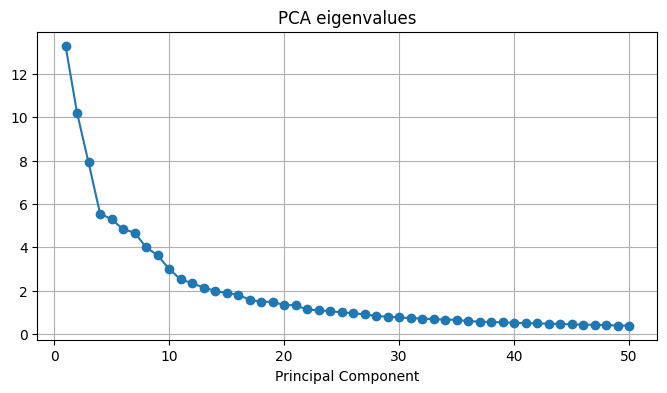

In [22]:
root_folder = "mushrooms"

all_embeds = []
for species in os.listdir(root_folder):
    species_folder = os.path.join(root_folder, species)
    
    embeds = embed_whole_folder(species_folder, bs = 8)
    all_embeds.append(embeds)

all_embeds = np.vstack(all_embeds)

reduced_embeds, pca_model = run_pca(all_embeds, n = 50)
plot_eigenvalues(pca_model)


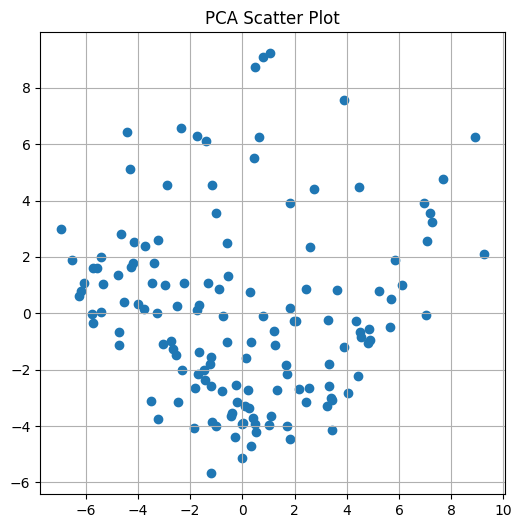

In [24]:
reduced_2d, pca_2d = run_pca(all_embeds, n = 2)
plot_pca_2d(reduced_2d)